In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 6

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

from scipy import stats

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import sys 
sys.path.append("../")
from KDG import KDG

Using TensorFlow backend.


# Experiment Parameters

In [40]:
num_trials = 50

# Data Generation

# Construct & Train Network

In [87]:
def construct_network(X, y):
    network = keras.Sequential()
    network.add(keras.layers.Dense(units=16, activation='relu', input_shape = np.shape(X)[1:]))
    network.add(keras.layers.Dense(units=16, activation='relu'))
    network.add(keras.layers.Dense(units=len(np.unique(y)), activation = 'softmax'))
    network.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(3e-4), metrics = ['acc'])
    network.fit(
      X, 
      keras.utils.to_categorical(y), 
      epochs = 60, 
      verbose = False,
      batch_size = int(2 ** (np.log(len(X)) / np.log(5) + 2.2))
    )
    return network

    

## Keurnal Networks

In [88]:
def train_AKN(X, y):
    X_transform, X, y_transform, y = train_test_split(X, y, test_size = 0.5)
    #X_transform, y_transform = X, y
    network = construct_network(X_transform, y_transform)
    polytope_memberships = []
    encoder = keras.models.Model(network.inputs, network.layers[-3].output)
    X = encoder.predict(X)
    last_activations = X
    for layer_id in range(len(network.layers) - 2, len(network.layers)):
        weights, bias = network.layers[layer_id].get_weights()
        preactivation = np.matmul(last_activations, weights) + bias
        if layer_id == len(network.layers) - 1:
            binary_preactivation = (preactivation > 0.2).astype('int')
        else:
            binary_preactivation = (preactivation > 0).astype('int')
        polytope_memberships.append(binary_preactivation)
        last_activations = preactivation * binary_preactivation

    polytope_memberships = [np.concatenate(polytope_memberships, axis = 1)]

    kdg = KDG().fit(X, y, polytope_memberships)
    return kdg, encoder

In [89]:
def clipped_mean(ra, low = 25, high = 75):
    ra = np.array(ra)
    lower_val = np.nanpercentile(ra, low)
    higher_val = np.nanpercentile(ra, high)
    return np.mean(ra[np.where((ra >= lower_val) & (ra <= higher_val))[0]])

In [90]:
def get_ece(predicted_posterior, y):
    hists = []
    hists_hat = []
    amts = []
    num_bins = 10
    eces_across_y_vals = []
    for y_val in np.unique(y):
        for i in range(num_bins):
            prop = i*1./num_bins
            inds = np.where((predicted_posterior[:, y_val] >= prop) & (predicted_posterior[:, y_val] <= prop+1./num_bins))[0]
            amts.append(len(inds))
            if len(inds) > 0:
                hists.append(len(np.where(y[inds] == y_val)[0])*1./len(inds))
                hists_hat.append(np.mean(predicted_posterior[inds, y_val]))
            else:
                hists.append(prop)
                hists_hat.append(prop + 0.5/num_bins)
        eces_across_y_vals.append(np.dot(np.abs(np.array(hists) - np.array(hists_hat)), amts) / np.sum(amts))
        return np.mean(eces_across_y_vals)

In [91]:
def get_brier(predicted_posterior, y):
    brier_across_y_vals = []
    for y_val in np.unique(y):
        brier_across_y_vals.append(np.nanmean((predicted_posterior[:, y_val] - (y == y_val).astype('int'))**2))
    return np.mean(brier_across_y_vals)

In [92]:
(X, y), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
train_indices, test_indices = np.where(y < 5)[0], np.where(y_test < 5)[0]
X, y = np.expand_dims(X[train_indices], axis = -1), y[train_indices]
X_unpadded = np.concatenate([X for _ in range(3)], axis = -1)
X = np.zeros((len(X_unpadded), 32, 32, 3))
X[:, :X_unpadded.shape[1], :X_unpadded.shape[2]] = X_unpadded

X_test, y_test = np.expand_dims(X_test[test_indices], axis = -1), y_test[test_indices]
X_test_unpadded = np.concatenate([X_test for _ in range(3)], axis = -1)
X_test = np.zeros((len(X_test_unpadded), 32, 32, 3))
X_test[:, :X_test_unpadded.shape[1], :X_test_unpadded.shape[2]] = X_test_unpadded

test_indices = np.random.choice(range(len(X_test)), 1000)
X_test, y_test = X_test[test_indices], y_test[test_indices]

In [93]:
'''
(X, y), (X_test, y_test) = keras.datasets.cifar10.load_data()
train_indices, test_indices = np.where(y < 2)[0], np.where(y_test < 2)[0]
X, y = X[train_indices], y[train_indices, 0]
X_test, y_test = X_test[test_indices], y_test[test_indices, 0]

test_indices = np.random.choice(range(len(X_test)), 1000)
X_test, y_test = X_test[test_indices], y_test[test_indices]
'''

'\n(X, y), (X_test, y_test) = keras.datasets.cifar10.load_data()\ntrain_indices, test_indices = np.where(y < 2)[0], np.where(y_test < 2)[0]\nX, y = X[train_indices], y[train_indices, 0]\nX_test, y_test = X_test[test_indices], y_test[test_indices, 0]\n\ntest_indices = np.random.choice(range(len(X_test)), 1000)\nX_test, y_test = X_test[test_indices], y_test[test_indices]\n'

In [94]:
base_network = keras.applications.resnet50.ResNet50(input_shape = np.shape(X)[1:], include_top = False, pooling = 'max')
X, X_test = base_network.predict(X), base_network.predict(X_test)

In [95]:
def get_network_y_proba(X, y, n, X_test):
    random_indices = np.random.choice(len(X), int(n))
    X, y = X[random_indices], y[random_indices]
    network = construct_network(X, y)
    return network.predict_proba(X_test)
    

def get_KDE_y_proba(X, y, n, X_test):
    random_indices = np.random.choice(len(X), int(n))
    kdg, encoder = train_AKN(X, y)
    X, y = encoder.predict(X[random_indices]), y[random_indices]
    X_test = encoder.predict(X_test)
    y_proba_test = kdg.predict_proba(X_test)
    y_proba_test_normalized = np.copy(y_proba_test)
    for y_val in range(np.shape(y_proba_test)[1]):
        y_proba_test_normalized[:, y_val] /= np.sum(y_proba_test, axis = 1)
    return y_proba_test_normalized

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide


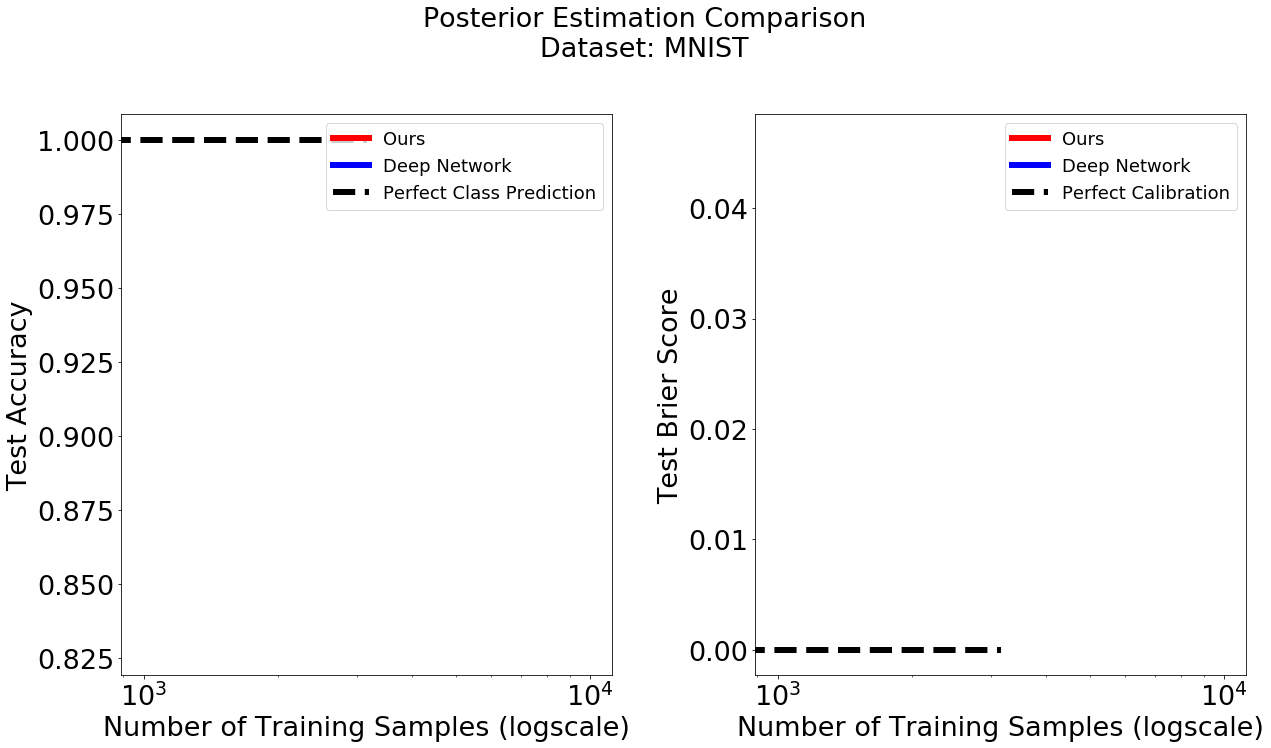

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide


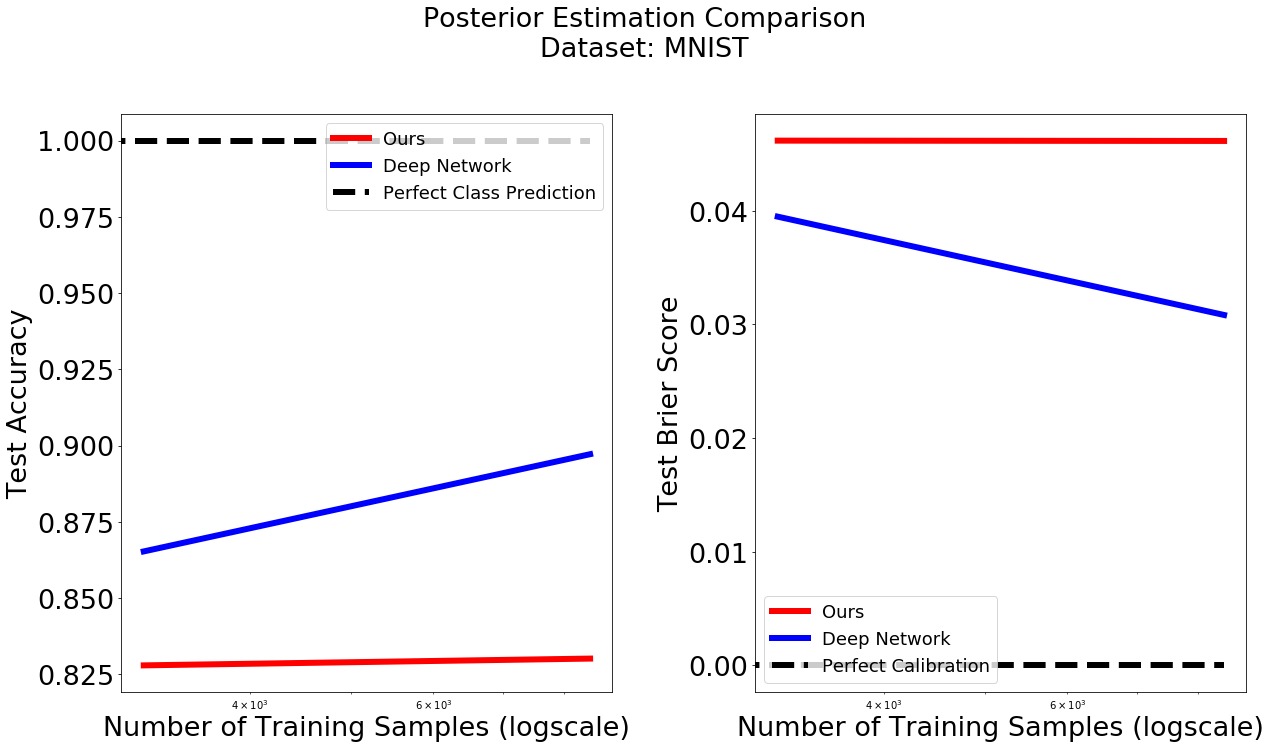

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide


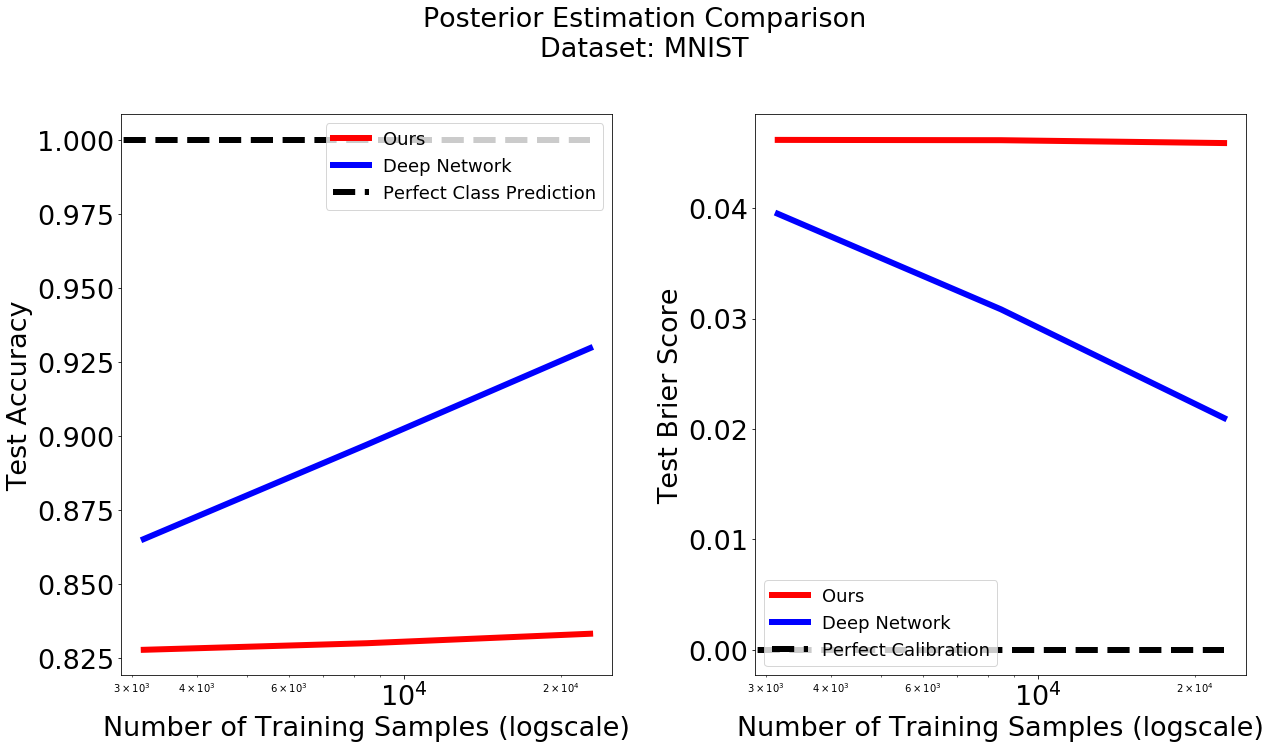

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide


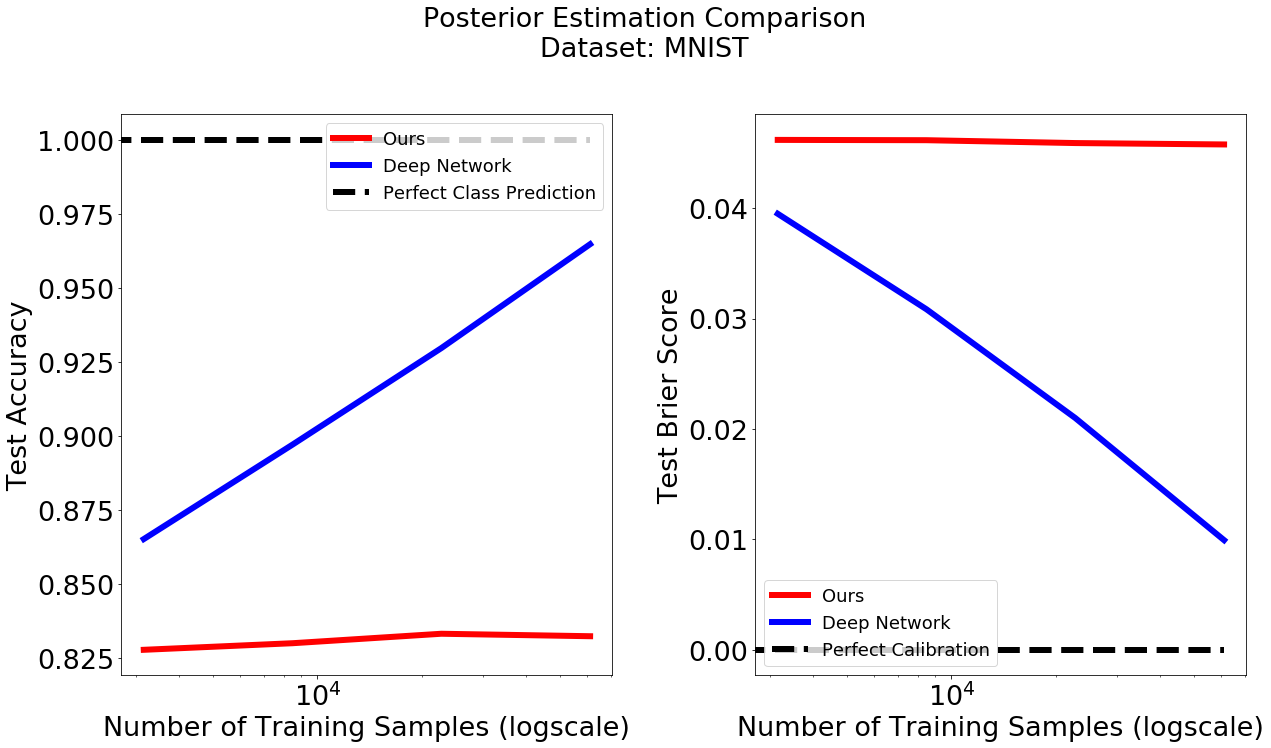

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide


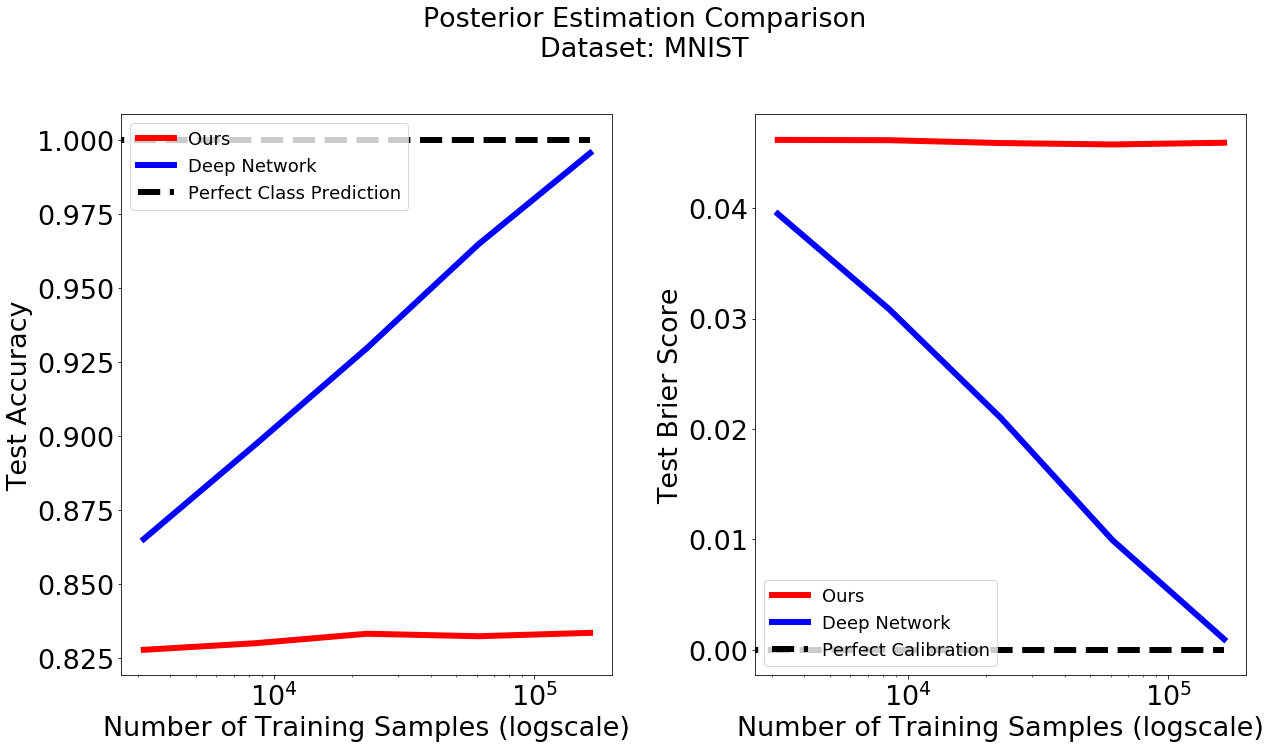

In [ ]:
KDE_acc_means = []
network_acc_means = []

KDE_brier_means = []
network_brier_means = []

n_ra = np.logspace(3.5, 6.5, num = 8, base = 10)
ticks = np.arange(np.min(n_ra), np.max(n_ra), step = int((np.max(n_ra) - np.min(n_ra)) // 4))
ticks_ra = np.array([int(str(tick)[:1]) * 10 ** int(np.log10(tick)) for tick in ticks])
for n in tqdm(n_ra):
    KDE_accs_across_trials = []
    network_accs_across_trials = []
    KDE_briers_across_trials = []
    network_briers_across_trials = []
    for trial_idx in tqdm(range(num_trials)):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        KDE_y_proba = get_KDE_y_proba(X_train, y_train, n, X_test)
        network_y_proba = get_network_y_proba(X, y, n, X_test)
        
        KDE_accs_across_trials.append(np.nanmean(np.argmax(KDE_y_proba, axis = 1) == y_test))
        network_accs_across_trials.append(np.nanmean(np.argmax(network_y_proba, axis = 1) == y_test))
        
        KDE_briers_across_trials.append(get_brier(KDE_y_proba, y_test))
        network_briers_across_trials.append(get_brier(network_y_proba, y_test))
        
    KDE_acc_means.append(clipped_mean(KDE_accs_across_trials))
    network_acc_means.append(clipped_mean(network_accs_across_trials))
    
    KDE_brier_means.append(clipped_mean(KDE_briers_across_trials, low = 0, high = 25))
    network_brier_means.append(clipped_mean(network_briers_across_trials, low = 0, high = 25))

    figs, ax = plt.subplots(1, 2, figsize = (18, 9))
    figs.set_facecolor("white")

    ax[0].tick_params(axis='both', which='major', labelsize=27)
    ax[0].plot(n_ra[:len(KDE_acc_means)] , KDE_acc_means, label = "Ours", c = "red")
    ax[0].plot(n_ra[:len(KDE_acc_means)], network_acc_means, label = "Deep Network", c = "blue")
    ax[0].hlines(1.0, 0, n_ra[len(KDE_acc_means) - 1], linestyle = "dashed", label = "Perfect Class Prediction", color = "black")
    ax[0].legend(fontsize = 18)
    ax[0].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
    ax[0].set_ylabel("Test Accuracy", fontsize = 27)
    ax[0].set_xscale("log")

    ax[1].tick_params(axis='both', which='major', labelsize=27)
    ax[1].plot(n_ra[:len(KDE_acc_means)] , KDE_brier_means, label = "Ours", c = "red")
    ax[1].plot(n_ra[:len(KDE_acc_means)], network_brier_means, label = "Deep Network", c = "blue")
    ax[1].hlines(0.0, 0, n_ra[len(KDE_acc_means) - 1], linestyle = "dashed", label = "Perfect Calibration", color = "black")
    ax[1].legend(fontsize = 18)
    ax[1].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
    ax[1].set_ylabel("Test Brier Score", fontsize = 27)
    ax[1].set_xscale("log")

    figs.tight_layout()

    figs.suptitle("Posterior Estimation Comparison\nDataset: MNIST", fontsize=27, y = 1.15)

    plt.show()

In [ ]:
figs, ax = plt.subplots(1, 2, figsize = (18, 9))
figs.set_facecolor("white")

ax[0].tick_params(axis='both', which='major', labelsize=27)
ax[0].plot(n_ra , KDE_acc_means, label = "Ours", c = "red")
ax[0].plot(n_ra, network_acc_means, label = "Deep Network", c = "blue")
ax[0].hlines(1.0, 0, n_ra[-1], linestyle = "dashed", label = "Perfect Class Prediction", color = "black")
ax[0].legend(fontsize = 18)
ax[0].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
ax[0].set_ylabel("Test Accuracy", fontsize = 27)
ax[0].set_xscale("log")

ax[1].tick_params(axis='both', which='major', labelsize=27)
ax[1].plot(n_ra , KDE_brier_means, label = "Ours", c = "red")
ax[1].plot(n_ra, network_brier_means, label = "Deep Network", c = "blue")
ax[1].hlines(0.0, 0, n_ra[-1], linestyle = "dashed", label = "Perfect Calibration", color = "black")
ax[1].legend(fontsize = 18)
ax[1].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
ax[1].set_ylabel("Test Brier Score", fontsize = 27)
ax[1].set_xscale("log")


figs.tight_layout()

figs.suptitle("Posterior Estimation Comparison\nDataset: Gaussian XOR w/ Sigma=0.1\nNetwork Widths={}".format(widths), fontsize=27, y = 1.15)

plt.show()